In [1]:
import numpy as np
import pandas as pd
import lifelines as ll

%matplotlib inline
import matplotlib.pyplot as plt

#larger
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

from lifelines.estimation import KaplanMeierFitter

/Users/bwu/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from lifelines.datasets import load_waltons
df = load_waltons()

In [3]:
df.head()

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137


In [4]:
T = df['T']
E = df['E']

In [5]:
#T is an array of durations
#E is a either boolean or binary array representing whether the “death” was observed (alternatively an individual can be censored).
#By default, lifelines assumes all “deaths” are observed.

In [6]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label = "Bay Area Homes"); # more succiently, kmf.fit(T,E)

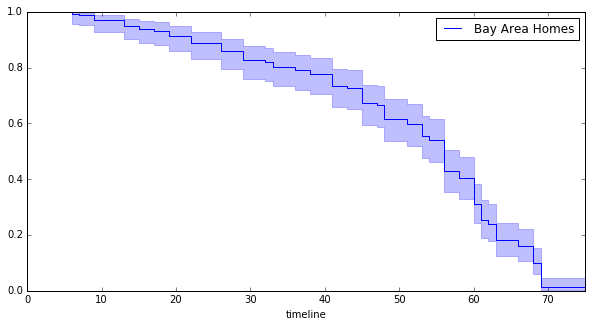

In [7]:
#After calling the fit method, we have access to new properties like survival_function_ and methods like plot(). 
#The latter is a wrapper around Pandas internal plotting library.
kmf.survival_function_
kmf.median_
kmf.plot();

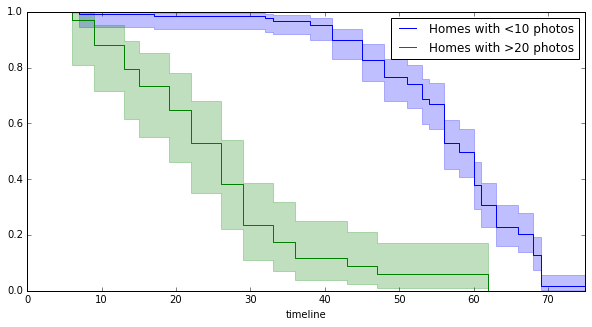

In [8]:
#Multiple Groups
groups = df['group']
ix = (groups == 'miR-137')

kmf.fit(T[~ix], E[~ix], label='Homes with <10 photos')
ax = kmf.plot()

kmf.fit(T[ix], E[ix], label='Homes with >20 photos')
kmf.plot(ax=ax);

In [9]:
from lifelines.utils import survival_table_from_events

table = survival_table_from_events(T, E)
table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0.0,0.0,0.0,163.0,163.0
6.0,1.0,1.0,0.0,0.0,163.0
7.0,2.0,1.0,1.0,0.0,162.0
9.0,3.0,3.0,0.0,0.0,160.0
13.0,3.0,3.0,0.0,0.0,157.0


In [10]:
#While the above KaplanMeierFitter and NelsonAalenFitter are useful, they only give us an “average” view of the population. 
#Often we have specific data at the individual level, either continuous or categorical, that we would like to use. 
#For this, we turn to survival regression, specifically AalenAdditiveFitter or CoxPHFitter.

In [11]:
from lifelines.datasets import load_regression_dataset
regression_dataset = load_regression_dataset()
regression_dataset.head()

,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785479,1
1,0.209325,0.184677,0.356980,7.336734,1
2,0.693919,0.071893,0.557960,5.271527,1
3,0.443804,1.364646,0.374221,11.684168,1
4,1.613324,0.125566,1.921325,7.637764,1


In [12]:
from lifelines import CoxPHFitter

# Using Cox Proportional Hazards model
cf = CoxPHFitter()
cf.fit(regression_dataset, 'T', event_col='E')
cf.print_summary()

n=200, number of events=189

          coef  exp(coef)  se(coef)         z         p  lower 0.95  upper 0.95    
var1 2.083e-01  1.232e+00 6.992e-02 2.980e+00 2.886e-03   7.126e-02   3.454e-01  **
var2 4.607e-02  1.047e+00 7.506e-02 6.139e-01 5.393e-01  -1.011e-01   1.932e-01    
var3 2.110e-01  1.235e+00 7.316e-02 2.884e+00 3.931e-03   6.754e-02   3.544e-01  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.580


In [13]:
#After fitting, you’ll have access to properties like cumulative_hazards_ and 
#methods like plot, predict_cumulative_hazards, and predict_survival_function. 
#The latter two methods require an additional argument of individual covariates:

/Users/bwu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  if __name__ == '__main__':


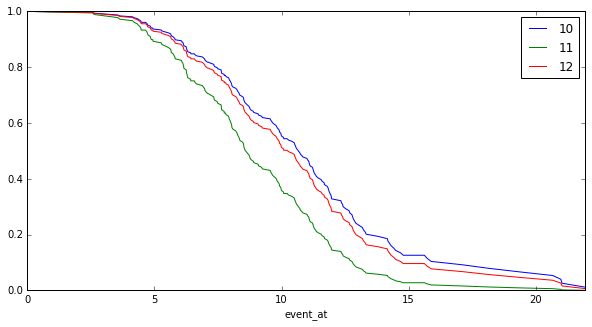

In [14]:
x = regression_dataset[regression_dataset.columns - ['E','T']]
cf.predict_survival_function(x.ix[10:12]).plot();

In [73]:
cf.predict_expectation(x.ix[10:12])

,0
10,10.882604
11,8.966119
12,10.409507


In [145]:
#For an experiment, using a canonical dataset called "Worcester Heart Attack Study (100 Patients)"
#https://www.umass.edu/statdata/statdata/stat-survival.html
#LENFOL: length of follow-up (days)
#FSTAT: loss to follow-up alive=0, death=1
#GENDER: males=0, females=1

In [19]:
df = pd.read_csv('whas100.csv')

In [20]:
df.head()

,id,admitdate,foldate,los,lenfol,fstat,age,gender,bmi
0,1,3/13/95,3/19/95,4,6,1,65,0,31.38134
1,2,1/14/95,1/23/96,5,374,1,88,1,22.65790
2,3,2/17/95,10/4/01,5,2421,1,77,0,27.87892
3,4,4/7/95,7/14/95,9,98,1,81,1,21.47878
4,5,2/9/95,5/29/98,4,1205,1,78,0,30.70601


In [21]:
kmf = KaplanMeierFitter()

In [22]:
T = df['lenfol']
C = df['fstat']

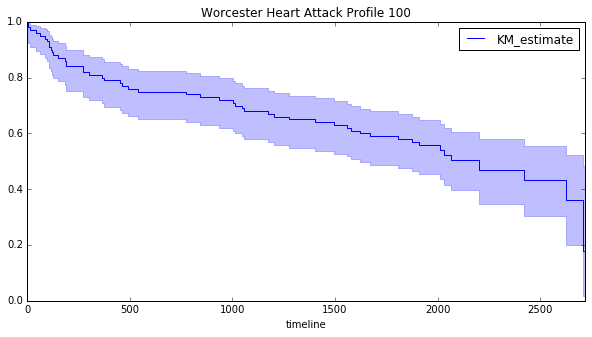

In [23]:
#kmf.fit(observed_lifetimes, event_observed=C)
kmf.fit(T, event_observed=C)
kmf.plot(title = 'Worcester Heart Attack Profile 100');

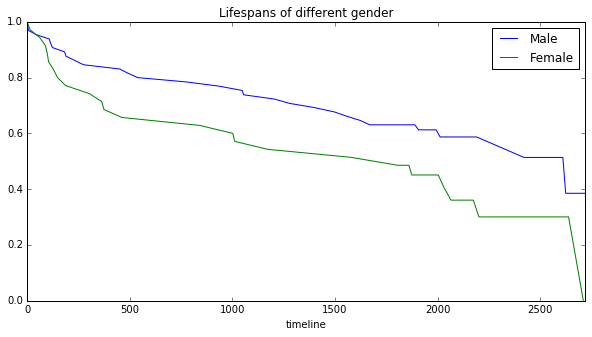

In [24]:
#male
f = df.gender==0
T = df[f]['lenfol']
C = df[f]['fstat']
#female
f2 = df.gender==1
T2 = df[f2]['lenfol']
C2 = df[f2]['fstat']

ax = plt.subplot(111)

kmf.fit(T, event_observed=C, label=['Male'])
kmf.survival_function_.plot(ax=ax)
kmf.fit(T2, event_observed=C2, label=['Female'])
kmf.survival_function_.plot(ax=ax)

plt.title('Lifespans of different gender')

kmf2 = plt.gcf()

#In the graph of the KM curve stratified by gender, 
#it means that females have a worse survival experience compared with male.

In [25]:
#Political regimes
data = ll.datasets.load_dd()

In [26]:
data.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


In [27]:
kmf = KaplanMeierFitter()
T = data["duration"]
C = data["observed"]

kmf.fit(T, event_observed=C )

<lifelines.KaplanMeierFitter: fitted with 1808 observations, 340 censored>

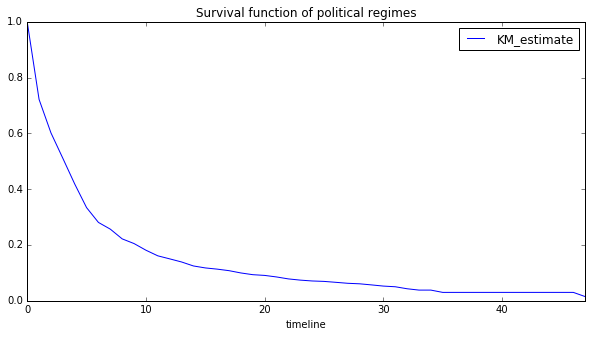

In [28]:
kmf.survival_function_.plot()
plt.title('Survival function of political regimes');

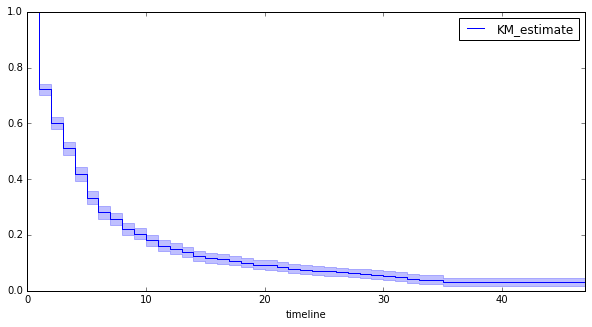

In [29]:
kmf.plot();

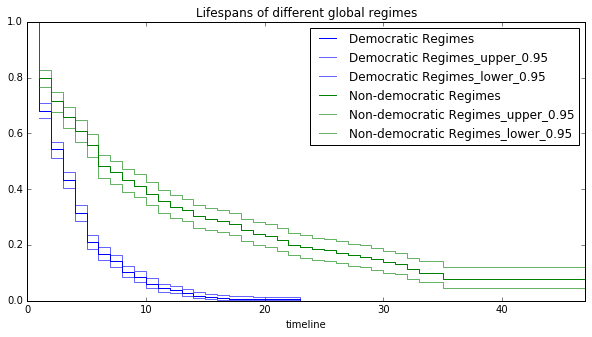

In [30]:
ax = plt.subplot(111)

dem = (data["democracy"] == "Democracy")
kmf.fit(T[dem], event_observed=C[dem], label="Democratic Regimes")
kmf.plot(ax=ax, ci_force_lines=True)
kmf.fit(T[~dem], event_observed=C[~dem], label="Non-democratic Regimes")
kmf.plot(ax=ax, ci_force_lines=True)

plt.ylim(0,1);
plt.title("Lifespans of different global regimes");

In [31]:
from lifelines.statistics import logrank_test

results = logrank_test(T[dem], T[~dem], C[dem], C[~dem], alpha=.99 )

results.print_summary()

Results
   df: 1
   alpha: 0.99
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00000 |            260.470 |      Reject Null    |        True       


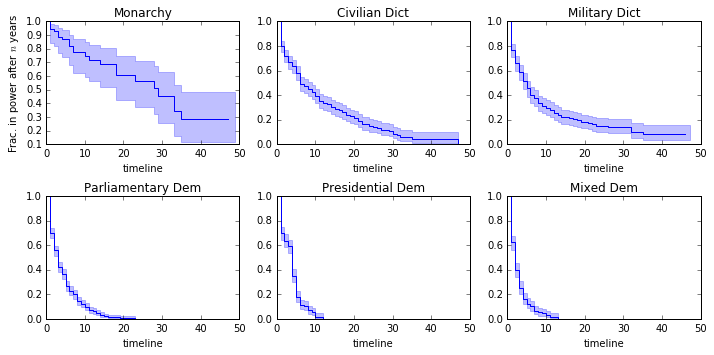

In [32]:
regime_types = data['regime'].unique()

for i,regime_type in enumerate(regime_types):
    ax = plt.subplot(2,3,i+1)
    ix = data['regime'] == regime_type
    kmf.fit( T[ix], C[ix], label=regime_type )
    kmf.plot(ax=ax, legend=False)
    plt.title(regime_type)
    plt.xlim(0,50)
    if i==0:
        plt.ylabel('Frac. in power after $n$ years')
plt.tight_layout()

In [12]:
#For listings data, they should be right-censored only. 
#That means for some listings we don’t know when they became pending, but we do know at least how many days they were listed.

In [128]:
import datetime
listings_df = pd.read_csv('SF_July15_31.csv')
final_date = pd.to_datetime('2016-07-31')

In [129]:
listings_df.pending_date = pd.to_datetime(listings_df.pending_date)
listings_df.listing_date = pd.to_datetime(listings_df.listing_date)
listings_df['days_til_pending'] = [diff.days if pd.notnull(diff) else 0 for diff in listings_df.pending_date - listings_df.listing_date]
listings_df['days_active_if_still_active'] = (final_date - listings_df.listing_date).dt.days
listings_df['price_psf'] = listings_df.price / listings_df.sqft

In [130]:
#alive = 0, dead = 1
listings_df['E'] = [0 if active == 0 else 1 for active in listings_df.days_til_pending]
listings_df['T'] = np.where(listings_df.days_til_pending == 0, listings_df.days_active_if_still_active, listings_df.days_til_pending)

In [131]:
listings_df.head()

,mprid,pending_date,listing_date,photo_count,type,bedrooms,year_built,sqft,price,days_til_pending,days_active_if_still_active,price_psf,E,T
0,1017992483,NaT,2016-05-31,8,single_family,3.0,2016.0,2623.0,1173509.0,0,61,447.391918,0,61
1,1020153053,NaT,2016-07-08,12,condo,1.0,1981.0,622.0,499000.0,0,23,802.250804,0,23
2,1050929893,2016-07-14,2016-07-08,4,multi_family,4.0,1944.0,1600.0,419500.0,6,23,262.187500,1,6
3,1131676967,NaT,2016-07-27,11,single_family,3.0,1951.0,1410.0,545000.0,0,4,386.524823,0,4
4,1202059063,NaT,2016-07-07,36,single_family,4.0,1976.0,2420.0,1139000.0,0,24,470.661157,0,24


In [133]:
#FILTER OUT "LAND", "MOBILE", "FARM"
listings_df = listings_df[(listings_df['type'] != 'land') & (listings_df['type'] != 'mobile') &  (listings_df['type'] != 'farm') ] 

#FILTER OUT HOMES < 100 SQFT
listings_df = listings_df[listings_df['sqft'] > 100]

#FILTER OUT OUTLIERS (> X DAYS LISTED)
listings_df = listings_df[listings_df['T'] < 180] 

In [132]:
listings_df.shape

(15091, 14)

In [135]:
listings_df[listings_df['T'] > 100].head()

,mprid,pending_date,listing_date,photo_count,type,bedrooms,year_built,sqft,price,days_til_pending,days_active_if_still_active,price_psf,E,T
135,1568007163,NaT,2016-03-03,2,single_family,4.0,2016.0,3526.0,1533949.0,0,150,435.039421,0,150
139,1695867989,NaT,2016-04-19,36,condo,2.0,2000.0,1407.0,1199000.0,0,103,852.167733,0,103
153,2592559539,NaT,2016-04-13,7,condo,1.0,1991.0,495.0,600000.0,0,109,1212.121212,0,109
163,1114088387,NaT,2016-03-09,8,multi_family,NaN,1958.0,3957.0,2399000.0,0,144,606.267374,0,144
213,1157533662,NaT,2016-04-18,11,multi_family,11.0,1900.0,3945.0,1725000.0,0,104,437.262357,0,104


In [136]:
from lifelines import KaplanMeierFitter

T = listings_df['T']
E = listings_df['E']

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label = "SF Bay Are CBSA Homes (July 2016)"); # more succiently, kmf.fit(T,E)

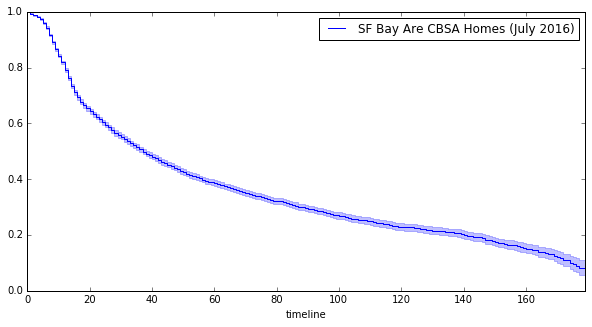

In [137]:
#After calling the fit method, we have access to new properties like survival_function_ and methods like plot(). 
#The latter is a wrapper around Pandas internal plotting library.
kmf.survival_function_
kmf.median_
kmf.plot(xlim = 0);

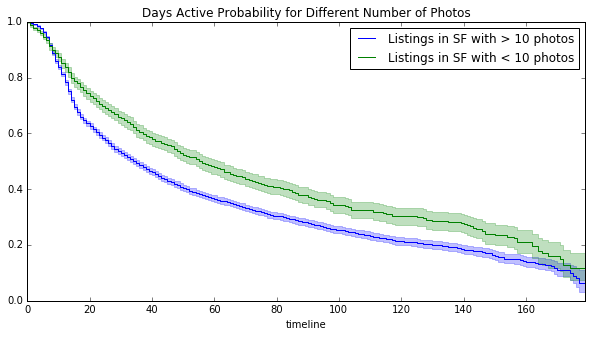

In [138]:
#Photo Counts
groups = listings_df['photo_count']
ten_photos_or_less = (groups <= 10)

kmf.fit(T[~ten_photos_or_less], E[~ten_photos_or_less], label='Listings in SF with > 10 photos')
ax = kmf.plot()

kmf.fit(T[ten_photos_or_less], E[ten_photos_or_less], label='Listings in SF with < 10 photos')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Number of Photos");

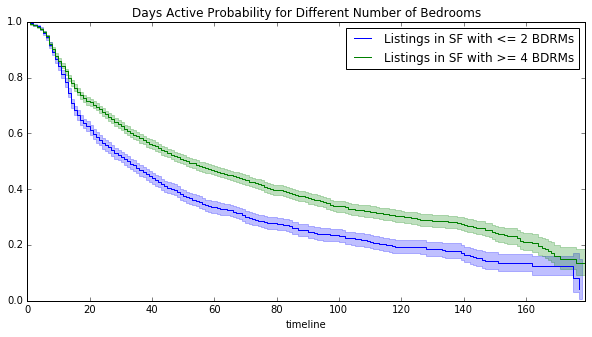

In [139]:
#Bedroom Counts
groups = listings_df['bedrooms']
two = (groups <= 2)
four = (groups >= 4)


kmf.fit(T[two], E[two], label='Listings in SF with <= 2 BDRMs')
ax = kmf.plot()

kmf.fit(T[four], E[four], label='Listings in SF with >= 4 BDRMs')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Number of Bedrooms");

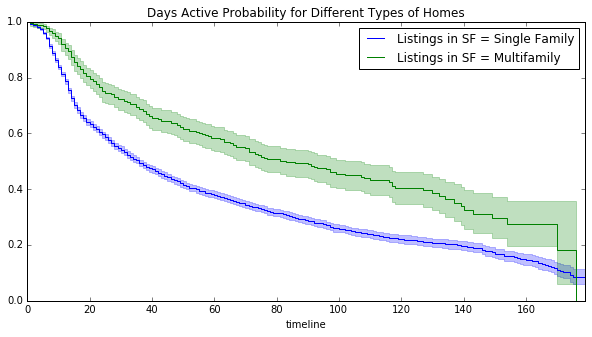

In [178]:
#Types of Home
groups = listings_df['type']
single = (groups == 'single_family')
multi = (groups == 'multi_family')

kmf.fit(T[single], E[single], label='Listings in SF = Single Family')
ax = kmf.plot()

kmf.fit(T[multi], E[multi], label='Listings in SF = Multifamily')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Types of Homes");

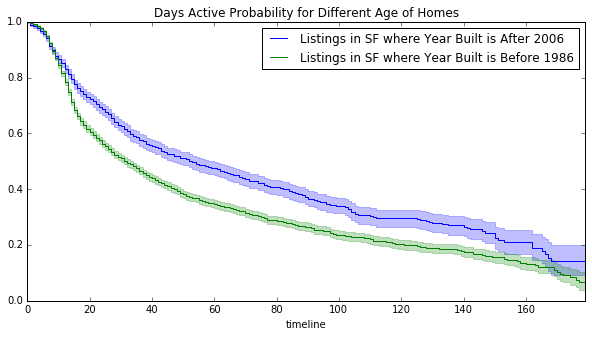

In [171]:
#Age of Homes
groups = listings_df['year_built']
new = ((groups >= 1996) & (groups < 2015))
old = (groups <= 1976)

kmf.fit(T[new], E[new], label='Listings in SF where Year Built is After 2006')
ax = kmf.plot()

kmf.fit(T[old], E[old], label='Listings in SF where Year Built is Before 1986')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Age of Homes");

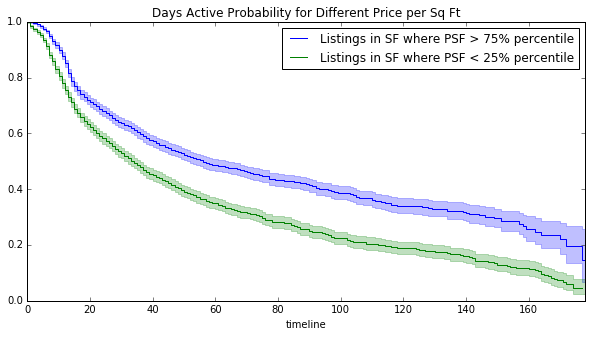

In [179]:
#Price Per SF
groups = listings_df['price_psf']
expensive = (groups >= 613)
cheap = (groups <= 332)

kmf.fit(T[expensive], E[expensive], label='Listings in SF where PSF > 75% percentile')
ax = kmf.plot()

kmf.fit(T[cheap], E[cheap], label='Listings in SF where PSF < 25% percentile')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Price per Sq Ft");

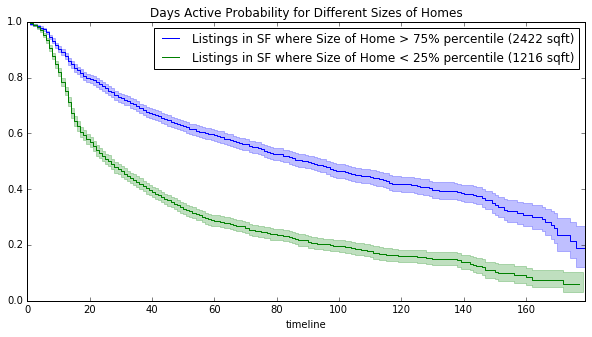

In [182]:
#Size of Home
groups = listings_df['sqft']
large = (groups >= 2422)
small = (groups <= 1216)

kmf.fit(T[large], E[large], label='Listings in SF where Size of Home > 75% percentile (2422 sqft)')
ax = kmf.plot()

kmf.fit(T[small], E[small], label='Listings in SF where Size of Home < 25% percentile (1216 sqft)')
kmf.plot(xlim=0,ax=ax,title="Days Active Probability for Different Sizes of Homes");